# 🤖 **Entraînement du Modèle ML pour le Matching CV-Job**

---

## 🎯 **Objectif**

Entraîner un modèle de Machine Learning capable de **prédire le score de matching** (`score_target`) entre un CV et une offre d'emploi à partir de **15 features** calculées.

**Avantages du modèle ML** :
- ⚡ **Plus rapide** que JobMatcher (pas de calcul de similarité en temps réel)
- 🎯 **Pré-filtrage** : éliminer rapidement les mauvais matchs avant calcul exact
- 📊 **Prédictions instantanées** pour des milliers d'offres

---

## 📊 **Dataset**

- **Fichier** : `data/processed/dataset_resume_job_fit_processed.xlsx`
- **Samples** : 6,241
- **Features** : 15 (numériques)
- **Target** : `score_target` (0, 0.5, 1)

---

## 📦 **1. Import des Librairies**

In [67]:
# Manipulation de données
import pandas as pd
import numpy as np

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Modèles
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

# Métriques de classification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Sauvegarde
import joblib
from pathlib import Path

# Configuration
import warnings
warnings.filterwarnings('ignore')

# Style des graphiques
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Librairies importées avec succès")

✅ Librairies importées avec succès


## 📥 **2. Chargement du Dataset**

In [68]:
# Chemin du dataset
data_path = Path('../data/resume_fit_job/processed/v2_dataset_resume_job_fit_processed.xlsx')

if not data_path.exists():
    raise FileNotFoundError(f"❌ Fichier non trouvé : {data_path}")

# Chargement
df = pd.read_excel(data_path, engine='openpyxl')

print(f"✅ Dataset chargé : {len(df):,} samples")
print(f"📊 Dimensions : {df.shape}")
print(f"\n📋 Colonnes disponibles :")
print(df.columns.tolist())

✅ Dataset chargé : 4,524 samples
📊 Dimensions : (4524, 16)

📋 Colonnes disponibles :
['coverage', 'quality', 'nb_covered_skills', 'nb_missing_skills', 'skills_ratio', 'similarity_mean', 'similarity_max', 'similarity_std', 'top3_similarity_avg', 'tfidf_similarity', 'embedding_similarity', 'nb_resume_technical', 'nb_resume_soft', 'nb_job_technical', 'nb_job_soft', 'score_target']


In [69]:
# Aperçu des données
print("\n🔍 Aperçu des 5 premières lignes :")
df.head()


🔍 Aperçu des 5 premières lignes :


,coverage,quality,nb_covered_skills,nb_missing_skills,skills_ratio,similarity_mean,similarity_max,similarity_std,top3_similarity_avg,tfidf_similarity,embedding_similarity,nb_resume_technical,nb_resume_soft,nb_job_technical,nb_job_soft,score_target
0,57.142857,60.841686,4,3,1.222222,60.841686,100.000015,22.881542,66.627670,0.141529,0.497848,4,7,5,4,0.0
1,63.636364,63.047329,14,8,1.000000,63.047329,100.000023,24.092339,100.000008,0.132432,0.385589,14,10,13,11,0.0
2,16.666667,46.124485,3,15,1.111111,46.124485,48.432777,3.105935,46.124485,0.165777,0.473125,8,12,14,4,0.0
3,33.333333,44.682732,1,2,2.333333,44.682732,44.682732,0.000000,44.682732,0.016166,0.506966,4,3,2,1,0.0
4,0.000000,0.000000,0,5,1.800000,0.000000,0.000000,0.000000,0.000000,0.094602,0.497814,4,5,4,1,0.0


In [70]:
# Informations générales
print("\n📊 Informations sur le dataset :")
df.info()


📊 Informations sur le dataset :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4524 entries, 0 to 4523
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   coverage              4524 non-null   float64
 1   quality               4524 non-null   float64
 2   nb_covered_skills     4524 non-null   int64  
 3   nb_missing_skills     4524 non-null   int64  
 4   skills_ratio          4524 non-null   float64
 5   similarity_mean       4524 non-null   float64
 6   similarity_max        4524 non-null   float64
 7   similarity_std        4524 non-null   float64
 8   top3_similarity_avg   4524 non-null   float64
 9   tfidf_similarity      4524 non-null   float64
 10  embedding_similarity  4524 non-null   float64
 11  nb_resume_technical   4524 non-null   int64  
 12  nb_resume_soft        4524 non-null   int64  
 13  nb_job_technical      4524 non-null   int64  
 14  nb_job_soft           4524 non-null   i

In [71]:
# Statistiques descriptives
print("\n📈 Statistiques descriptives :")
df.describe()


📈 Statistiques descriptives :


,coverage,quality,nb_covered_skills,nb_missing_skills,skills_ratio,similarity_mean,similarity_max,similarity_std,top3_similarity_avg,tfidf_similarity,embedding_similarity,nb_resume_technical,nb_resume_soft,nb_job_technical,nb_job_soft,score_target
count,4524.000000,4524.000000,4524.000000,4524.000000,4524.000000,4524.000000,4524.000000,4524.000000,4524.000000,4524.000000,4524.000000,4524.000000,4524.000000,4524.000000,4524.000000,4524.000000
mean,54.810506,63.248065,6.656941,6.099469,3.165321,63.248065,87.759154,17.767637,78.106820,0.176469,0.516397,15.109195,6.969717,8.143899,4.597922,0.365164
std,22.800030,16.563654,4.664787,5.385129,4.508413,16.563654,23.926753,9.682304,23.237084,0.099855,0.125350,12.999023,3.883810,6.975262,3.523762,0.402773
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.002673,1.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,54.075301,3.000000,2.000000,1.000000,54.075301,99.999992,8.612669,63.899009,0.104572,0.435482,6.000000,4.000000,3.000000,2.000000,0.000000
50%,54.545455,64.062744,6.000000,4.000000,1.750000,64.062740,100.000015,22.188800,84.172359,0.161067,0.525212,11.000000,6.000000,6.000000,4.000000,0.500000
75%,66.666667,72.748999,9.000000,9.000000,3.500000,72.748993,100.000023,24.816488,100.000000,0.229025,0.606340,21.000000,9.000000,12.000000,7.000000,0.500000
max,100.000000,100.000023,30.000000,31.000000,97.000000,100.000023,100.000038,29.955326,100.000023,0.627715,0.842405,98.000000,25.000000,30.000000,20.000000,1.000000


In [72]:
# Vérification des valeurs manquantes
print("\n🔍 Valeurs manquantes :")
missing = df.isnull().sum()

if missing.sum() == 0:
    print("✅ Aucune valeur manquante")
else:
    print(missing[missing > 0])


🔍 Valeurs manquantes :
✅ Aucune valeur manquante


## 📊 **3. Analyse Exploratoire des Données (EDA)**

### **3.1 Distribution du Target (`score_target`)**

In [73]:
# Statistiques du target
print("📊 Statistiques de score_target :")
print(f"   • Minimum  : {df['score_target'].min():.2f}")
print(f"   • Maximum  : {df['score_target'].max():.2f}")
print(f"   • Moyenne  : {df['score_target'].mean():.2f}")
print(f"   • Médiane  : {df['score_target'].median():.2f}")
print(f"   • Écart-type : {df['score_target'].std():.2f}")

# Distribution des valeurs
print(f"\n📊 Distribution des valeurs :")
print(df['score_target'].value_counts().sort_index())

📊 Statistiques de score_target :
   • Minimum  : 0.00
   • Maximum  : 1.00
   • Moyenne  : 0.37
   • Médiane  : 0.50
   • Écart-type : 0.40

📊 Distribution des valeurs :
score_target
0.0    2242
0.5    1260
1.0    1022
Name: count, dtype: int64


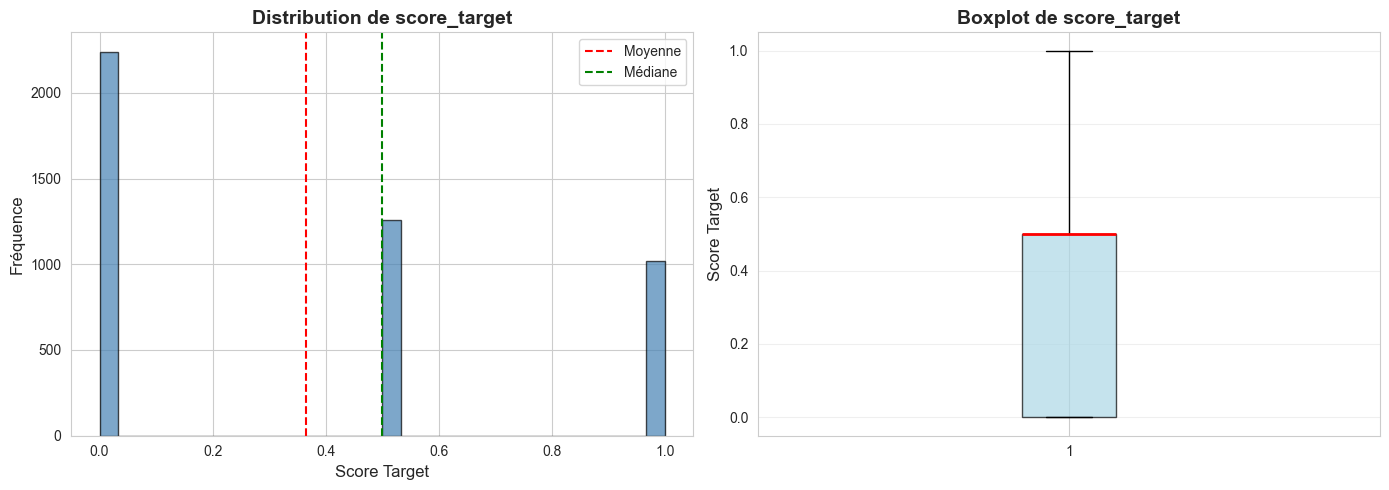

✅ Distribution du target visualisée


In [74]:
# Visualisation de la distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogramme
axes[0].hist(df['score_target'], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_xlabel('Score Target', fontsize=12)
axes[0].set_ylabel('Fréquence', fontsize=12)
axes[0].set_title('Distribution de score_target', fontsize=14, fontweight='bold')
axes[0].axvline(df['score_target'].mean(), color='red', linestyle='--', label='Moyenne')
axes[0].axvline(df['score_target'].median(), color='green', linestyle='--', label='Médiane')
axes[0].legend()

# Boxplot
axes[1].boxplot(df['score_target'], vert=True, patch_artist=True,
                boxprops=dict(facecolor='lightblue', alpha=0.7),
                medianprops=dict(color='red', linewidth=2))
axes[1].set_ylabel('Score Target', fontsize=12)
axes[1].set_title('Boxplot de score_target', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Distribution du target visualisée")

### **3.2 Distribution des Features**

In [75]:
# Liste des features (exclure score_target)
features = [
    'coverage', 'quality', 'nb_covered_skills', 'nb_missing_skills',
    'skills_ratio', 'similarity_mean', 'similarity_max', 'similarity_std',
    'top3_similarity_avg', 'tfidf_similarity', 'embedding_similarity',
    'nb_resume_technical', 'nb_resume_soft', 'nb_job_technical', 'nb_job_soft'
]

print(f"📊 Features à analyser : {len(features)}")
print(features)

📊 Features à analyser : 15
['coverage', 'quality', 'nb_covered_skills', 'nb_missing_skills', 'skills_ratio', 'similarity_mean', 'similarity_max', 'similarity_std', 'top3_similarity_avg', 'tfidf_similarity', 'embedding_similarity', 'nb_resume_technical', 'nb_resume_soft', 'nb_job_technical', 'nb_job_soft']


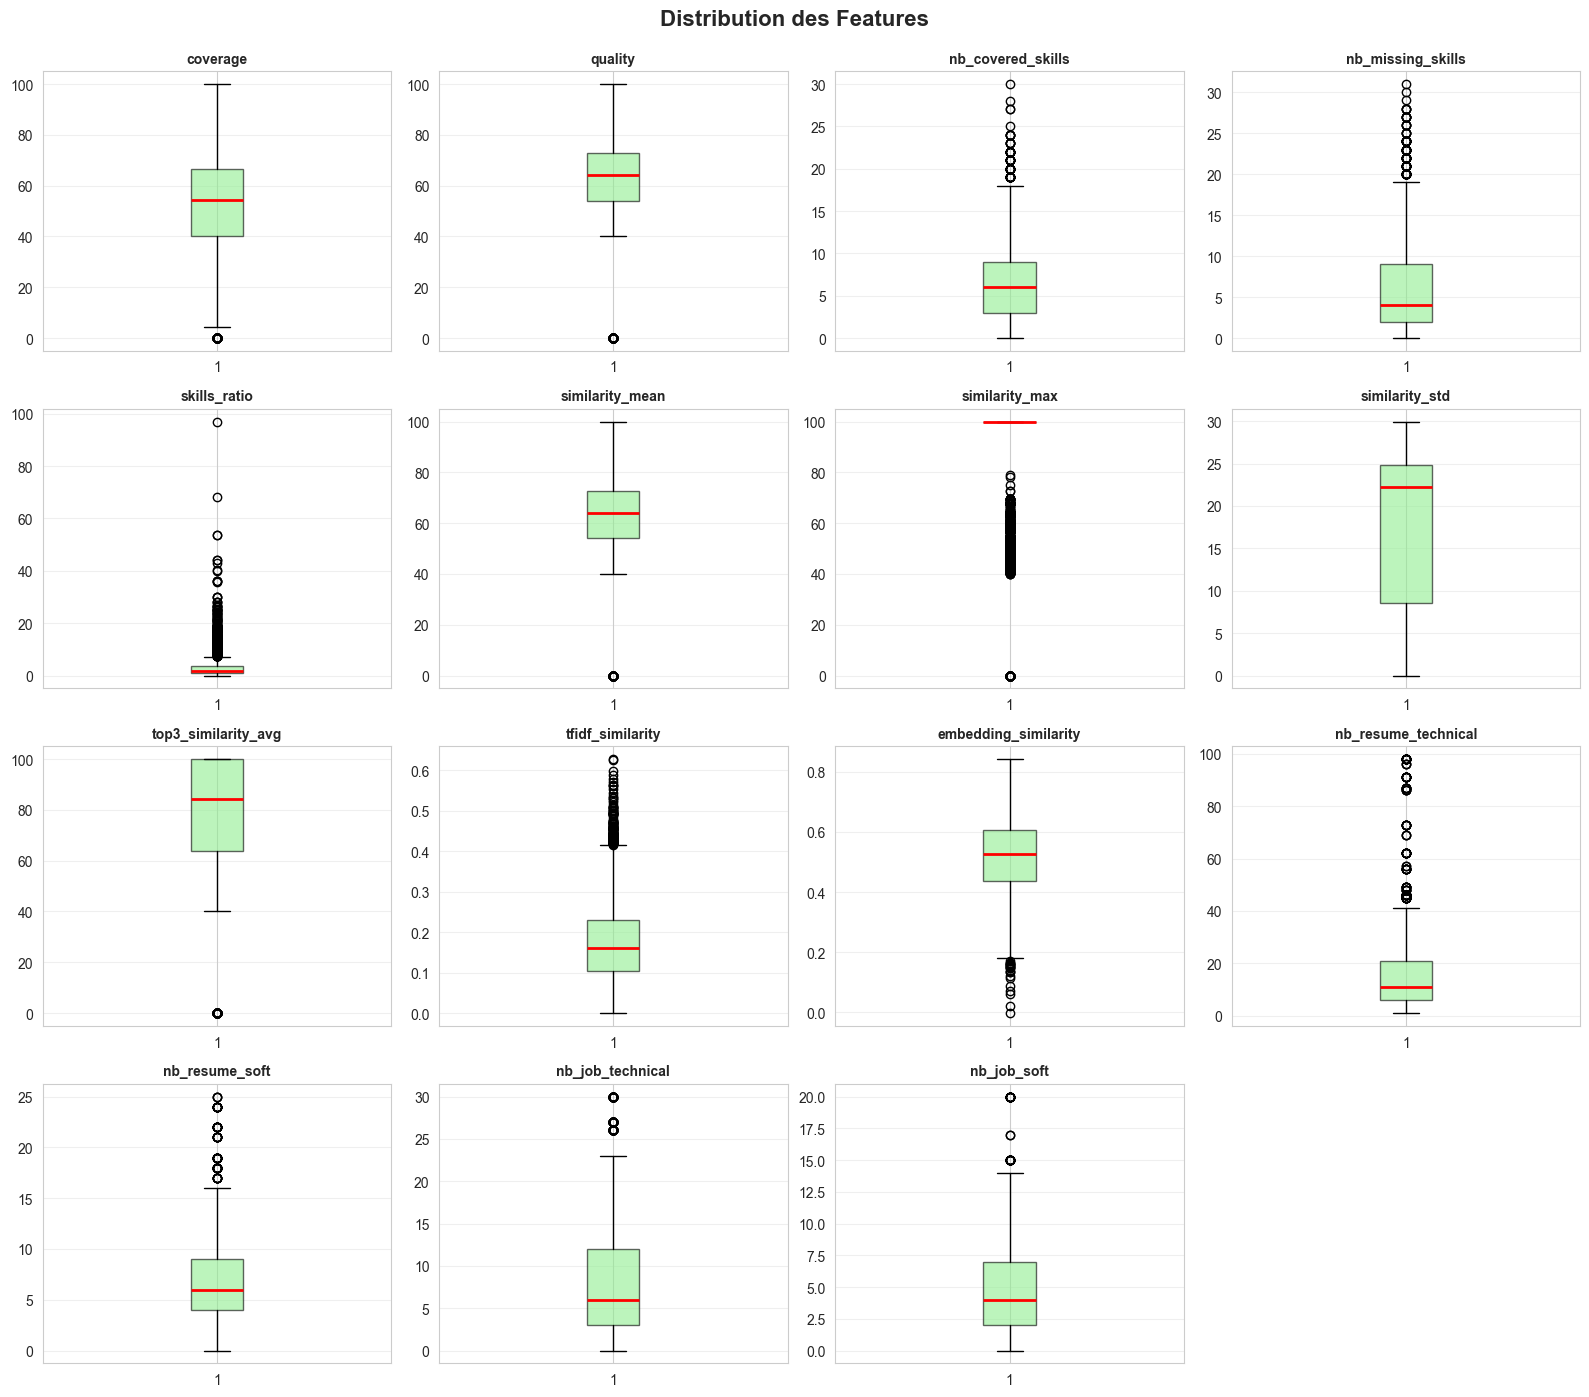

✅ Distribution des features visualisée


In [76]:
# Boxplots des features (4x4 grid)
fig, axes = plt.subplots(4, 4, figsize=(16, 14))
axes = axes.flatten()

for idx, feature in enumerate(features):
    axes[idx].boxplot(df[feature], vert=True, patch_artist=True,
                     boxprops=dict(facecolor='lightgreen', alpha=0.6),
                     medianprops=dict(color='red', linewidth=2))
    axes[idx].set_title(feature, fontsize=10, fontweight='bold')
    axes[idx].grid(axis='y', alpha=0.3)

# Cacher l'axe vide (16ème)
axes[15].axis('off')

plt.suptitle('Distribution des Features', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("✅ Distribution des features visualisée")

### **3.3 Matrice de Corrélation**

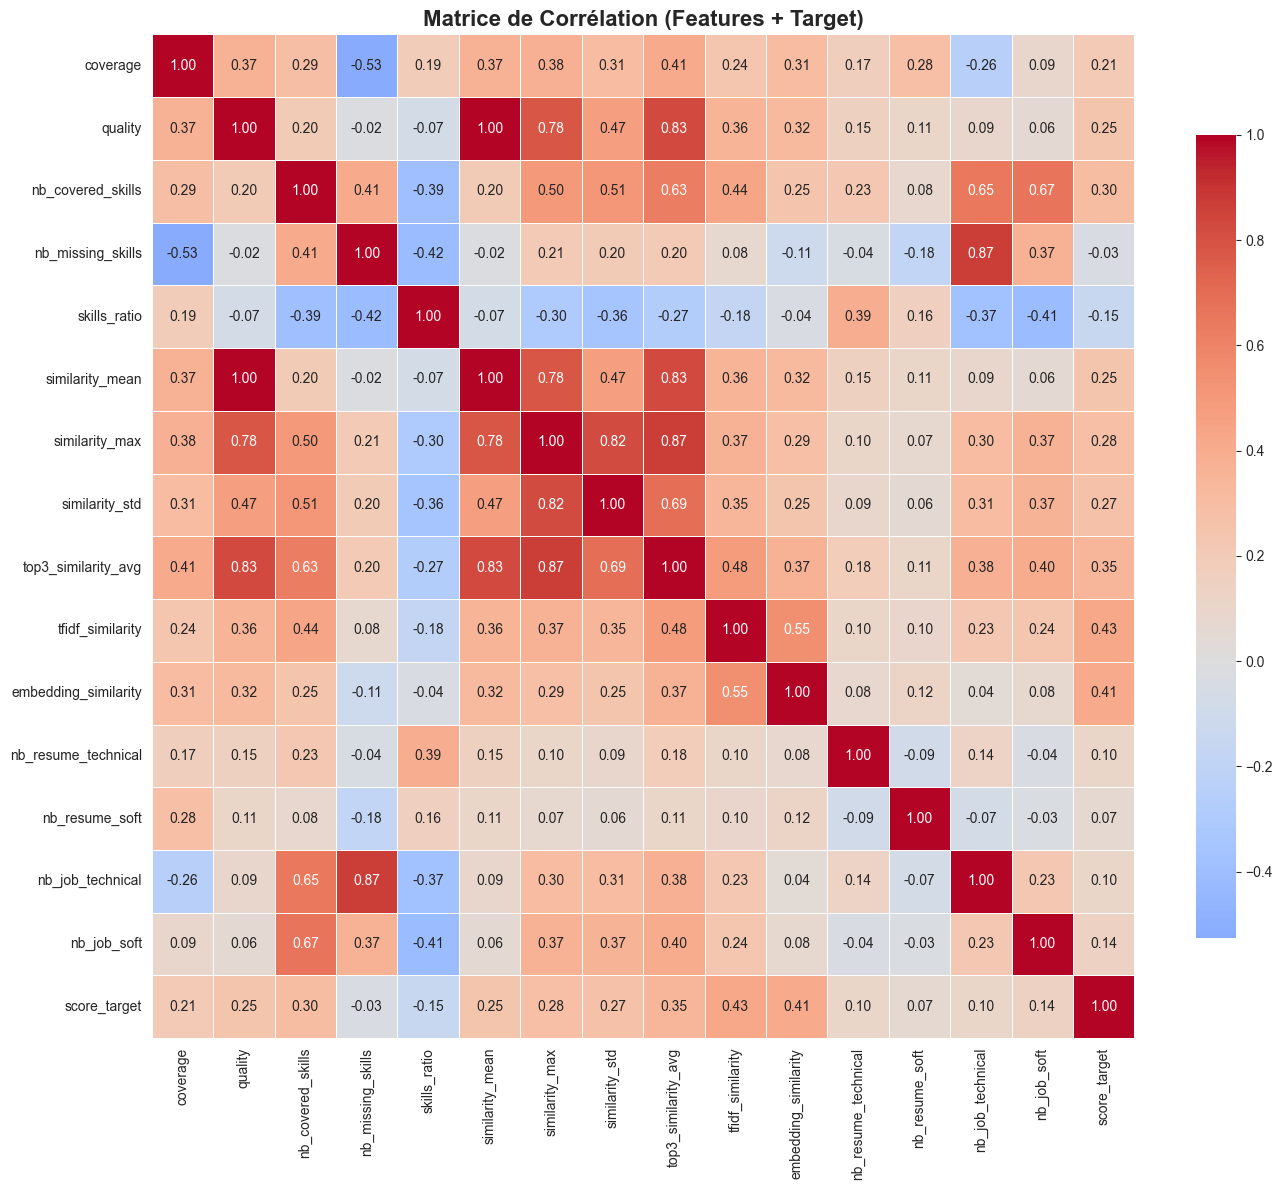

✅ Matrice de corrélation visualisée


In [77]:
# Calculer la matrice de corrélation
correlation_matrix = df[features + ['score_target']].corr()

# Heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Matrice de Corrélation (Features + Target)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("✅ Matrice de corrélation visualisée")


📊 Corrélations avec score_target (triées par importance) :
tfidf_similarity        0.425549
embedding_similarity    0.409782
top3_similarity_avg     0.348739
nb_covered_skills       0.301332
similarity_max          0.282143
similarity_std          0.268433
similarity_mean         0.246858
quality                 0.246858
coverage                0.205430
nb_job_soft             0.137432
nb_job_technical        0.104530
nb_resume_technical     0.103421
nb_resume_soft          0.068481
nb_missing_skills      -0.031785
skills_ratio           -0.153445
Name: score_target, dtype: float64


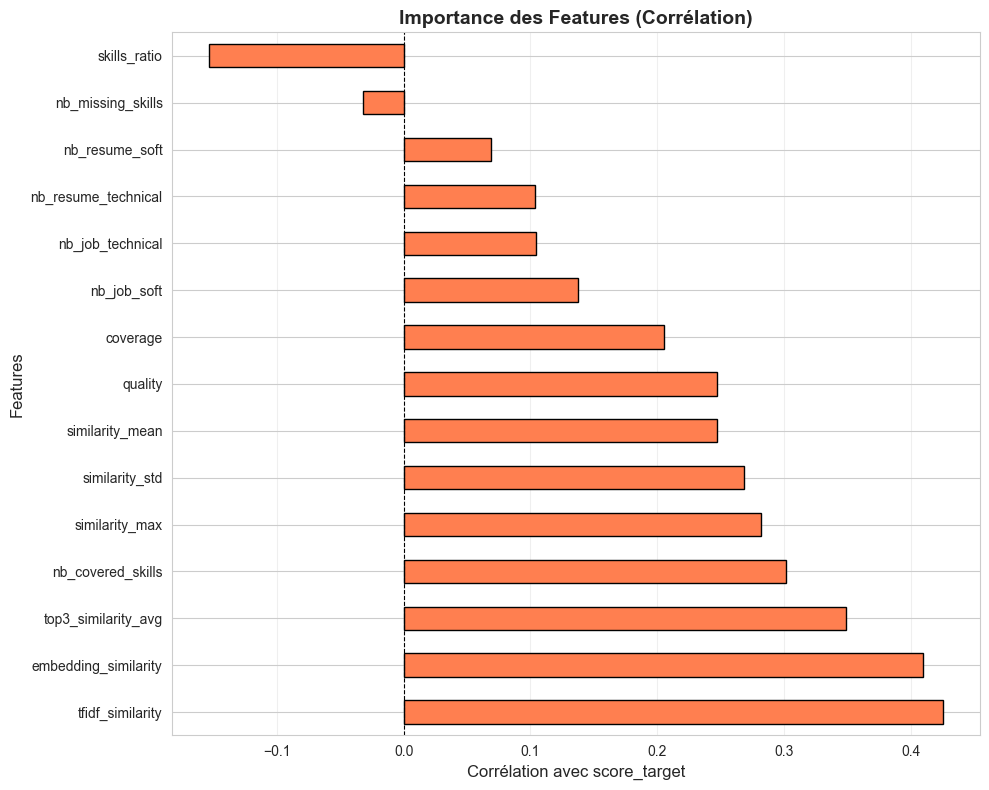


🎯 Top 5 features les plus corrélées :
   1. tfidf_similarity          → 0.426
   2. embedding_similarity      → 0.410
   3. top3_similarity_avg       → 0.349
   4. nb_covered_skills         → 0.301
   5. similarity_max            → 0.282


In [78]:
# Corrélations avec le target
target_correlations = correlation_matrix['score_target'].drop('score_target').sort_values(ascending=False)

print("\n📊 Corrélations avec score_target (triées par importance) :")
print(target_correlations)

# Visualisation
plt.figure(figsize=(10, 8))
target_correlations.plot(kind='barh', color='coral', edgecolor='black')
plt.xlabel('Corrélation avec score_target', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Importance des Features (Corrélation)', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n🎯 Top 5 features les plus corrélées :")
for i, (feat, corr) in enumerate(target_correlations.head(5).items(), 1):
    print(f"   {i}. {feat:25} → {corr:.3f}")

### **3.4 Pairplot des Top Features**


📊 Pairplot des 5 features les plus corrélées :
['tfidf_similarity', 'embedding_similarity', 'top3_similarity_avg', 'nb_covered_skills', 'similarity_max']


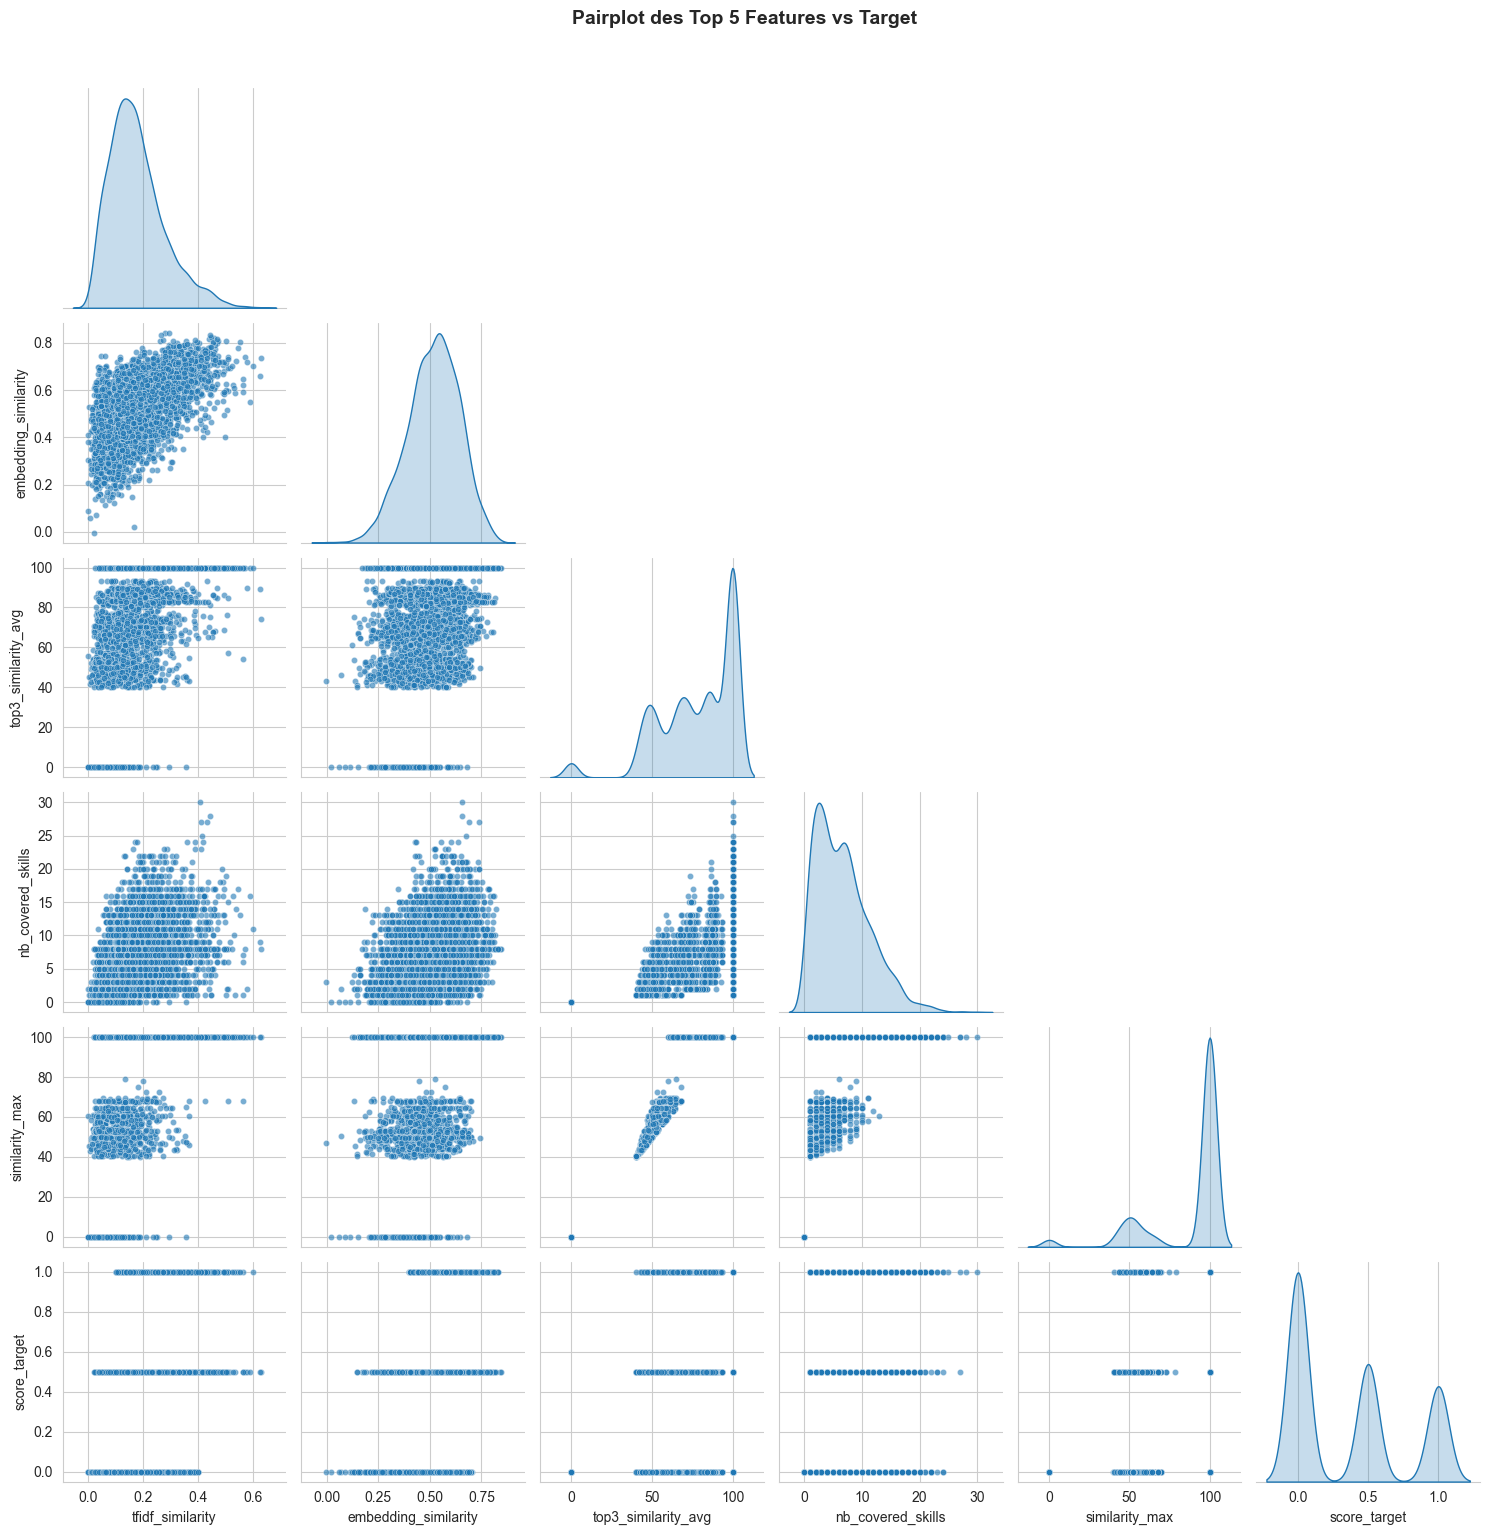

✅ Pairplot visualisé


In [79]:
# Sélectionner les 5 features les plus corrélées
top5_features = target_correlations.head(5).index.tolist()

print(f"\n📊 Pairplot des 5 features les plus corrélées :")
print(top5_features)

# Créer le pairplot
pairplot_data = df[top5_features + ['score_target']]
sns.pairplot(pairplot_data, diag_kind='kde', corner=True, 
             plot_kws={'alpha': 0.6, 's': 20}, height=2.5)
plt.suptitle('Pairplot des Top 5 Features vs Target', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("✅ Pairplot visualisé")

## 🔧 **4. Préparation des Données**

### **4.1 Séparation Features / Target**

In [80]:
# Séparer X (features) et y (target)
X = df[features].copy()
y = df['score_target'].copy()

print(f"✅ Données séparées :")
print(f"   • X (features) : {X.shape}")
print(f"   • y (target)   : {y.shape}")

✅ Données séparées :
   • X (features) : (4524, 15)
   • y (target)   : (4524,)


### **4.2 Train/Test Split**

In [81]:
# Split 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

print(f"✅ Données divisées (80% train / 20% test) :")
print(f"   • X_train : {X_train.shape}")
print(f"   • X_test  : {X_test.shape}")
print(f"   • y_train : {y_train.shape}")
print(f"   • y_test  : {y_test.shape}")

# Vérifier la distribution du target dans train/test
print(f"\n📊 Distribution du target :")
print(f"   • Train - Mean: {y_train.mean():.2f}, Std: {y_train.std():.2f}")
print(f"   • Test  - Mean: {y_test.mean():.2f}, Std: {y_test.std():.2f}")

✅ Données divisées (80% train / 20% test) :
   • X_train : (3619, 15)
   • X_test  : (905, 15)
   • y_train : (3619,)
   • y_test  : (905,)

📊 Distribution du target :
   • Train - Mean: 0.37, Std: 0.40
   • Test  - Mean: 0.35, Std: 0.41


### **4.3 Normalisation (StandardScaler)**

In [82]:
# Créer le scaler
scaler = StandardScaler()

# Fit sur train, transform sur train et test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convertir en DataFrame pour garder les noms de colonnes
X_train_scaled = pd.DataFrame(X_train_scaled, columns=features, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=features, index=X_test.index)

print(f"✅ Données normalisées (StandardScaler)")
print(f"\n📊 Aperçu des données après normalisation :")
display(X_train_scaled.head())

print(f"\n📊 Statistiques après normalisation (Train) :")
print(f"   • Mean : {X_train_scaled.mean().mean():.6f} (proche de 0)")
print(f"   • Std  : {X_train_scaled.std().mean():.6f} (proche de 1)")

✅ Données normalisées (StandardScaler)

📊 Aperçu des données après normalisation :


,coverage,quality,nb_covered_skills,nb_missing_skills,skills_ratio,similarity_mean,similarity_max,similarity_std,top3_similarity_avg,tfidf_similarity,embedding_similarity,nb_resume_technical,nb_resume_soft,nb_job_technical,nb_job_soft
1503,-0.949387,-0.671125,-1.219955,-0.762216,1.633989,-0.671125,-1.493652,-1.839477,-1.122045,-1.192272,0.989049,0.665694,0.012840,-0.889897,-1.023241
4186,0.227182,-0.192443,-0.790687,-0.762216,0.380906,-0.192443,-0.777208,-0.628216,-0.781513,-0.677726,-0.356676,0.211809,-0.246766,-0.598893,-1.023241
251,1.992035,-0.050951,-0.790687,-1.137644,0.954607,-0.050951,0.509757,0.910510,-0.680856,-0.730155,0.097825,-0.695961,2.349294,-0.889897,-1.023241
4318,1.732498,1.599288,1.999552,-0.949930,0.737582,1.599288,0.509757,0.128263,0.935535,2.435321,1.036804,6.112313,-0.246766,1.147128,-1.307091
3905,-0.949387,-1.059404,-0.146786,1.114925,-0.542552,-1.059404,-1.469440,-1.489084,-1.300070,-0.631420,-0.769174,-0.469019,-0.765977,0.856125,-0.171691



📊 Statistiques après normalisation (Train) :
   • Mean : 0.000000 (proche de 0)
   • Std  : 1.000138 (proche de 1)


In [83]:
# ========== ENCODER LES CLASSES ==========
# Problème : y contient des floats (0.0, 0.5, 1.0)
# Solution : Mapper vers des entiers (0, 1, 2)

print("\n🔄 Encodage des classes...")

# Mapping : 0.0 → 0, 0.5 → 1, 1.0 → 2
class_mapping = {0.0: 0, 0.5: 1, 1.0: 2}
reverse_mapping = {0: 0.0, 1: 0.5, 2: 1.0}

# Appliquer le mapping
y_train_encoded = y_train.map(class_mapping)
y_test_encoded = y_test.map(class_mapping)

print(f"✅ Classes encodées :")
print(f"   • Classes originales : {sorted(y.unique())}")
print(f"   • Classes encodées   : {sorted(y_train_encoded.unique())}")
print(f"\n📊 Distribution des classes (Train) :")
print(y_train_encoded.value_counts().sort_index())
print(f"\n📊 Distribution des classes (Test) :")
print(y_test_encoded.value_counts().sort_index())


🔄 Encodage des classes...
✅ Classes encodées :
   • Classes originales : [np.float64(0.0), np.float64(0.5), np.float64(1.0)]
   • Classes encodées   : [np.int64(0), np.int64(1), np.int64(2)]

📊 Distribution des classes (Train) :
score_target
0    1770
1    1030
2     819
Name: count, dtype: int64

📊 Distribution des classes (Test) :
score_target
0    472
1    230
2    203
Name: count, dtype: int64


## 🤖 **5. Entraînement des Modèles de Classification**

### **5.1 Définition des Modèles**

**Note** : `score_target` a 3 classes (0, 0.5, 1). On utilise des **modèles de classification multi-classes**.

In [84]:
# Dictionnaire des modèles à tester
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1, verbosity=0, eval_metric='mlogloss'),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42, early_stopping=True)
}

print(f"✅ {len(models)} modèles de classification définis :")
for name in models.keys():
    print(f"   • {name}")

✅ 5 modèles de classification définis :
   • Logistic Regression
   • Random Forest
   • Gradient Boosting
   • XGBoost
   • Neural Network


### **5.2 Entraînement et Évaluation**

In [85]:
# Fonction d'évaluation pour classification
def evaluate_classifier(model, X_train, y_train, X_test, y_test, model_name):
    """
    Entraîner et évaluer un modèle de classification
    """
    # Entraînement
    model.fit(X_train, y_train)
    
    # Prédictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Métriques Train
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_precision = precision_score(y_train, y_train_pred, average='weighted', zero_division=0)
    train_recall = recall_score(y_train, y_train_pred, average='weighted', zero_division=0)
    train_f1 = f1_score(y_train, y_train_pred, average='weighted', zero_division=0)
    
    # Métriques Test
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred, average='weighted', zero_division=0)
    test_recall = recall_score(y_test, y_test_pred, average='weighted', zero_division=0)
    test_f1 = f1_score(y_test, y_test_pred, average='weighted', zero_division=0)
    
    return {
        'Model': model_name,
        'Train Accuracy': train_accuracy,
        'Train Precision': train_precision,
        'Train Recall': train_recall,
        'Train F1-Score': train_f1,
        'Test Accuracy': test_accuracy,
        'Test Precision': test_precision,
        'Test Recall': test_recall,
        'Test F1-Score': test_f1,
        'Overfitting': train_accuracy - test_accuracy
    }

print("✅ Fonction d'évaluation définie")

✅ Fonction d'évaluation définie


In [86]:
# Entraîner tous les modèles
results = []

print("🔄 Entraînement des modèles en cours...\n")

for name, model in models.items():
    print(f"   • Entraînement de {name}...")
    
    try:
        # Tous les modèles utilisent les données normalisées ET les classes encodées
        result = evaluate_classifier(model, X_train_scaled, y_train_encoded, X_test_scaled, y_test_encoded, name)
        results.append(result)
        print(f"     ✅ {name} : Test Accuracy = {result['Test Accuracy']:.4f}")
    except Exception as e:
        print(f"     ❌ Erreur avec {name}: {str(e)}")

print("\n✅ Entraînement terminé")

🔄 Entraînement des modèles en cours...

   • Entraînement de Logistic Regression...
     ✅ Logistic Regression : Test Accuracy = 0.5867
   • Entraînement de Random Forest...
     ✅ Random Forest : Test Accuracy = 0.6729
   • Entraînement de Gradient Boosting...
     ✅ Gradient Boosting : Test Accuracy = 0.6597
   • Entraînement de XGBoost...
     ✅ XGBoost : Test Accuracy = 0.7017
   • Entraînement de Neural Network...
     ✅ Neural Network : Test Accuracy = 0.6122

✅ Entraînement terminé


In [87]:
# ========== RÈGLES DE COHÉRENCE MÉTIER ==========

def is_incoherent(row):
    """
    Identifier les lignes incohérentes selon des règles métier
    
    Règles :
    - NO FIT (0.0) : coverage/quality/similarity devraient être FAIBLES
    - PERFECT FIT (1.0) : coverage/quality/similarity devraient être ÉLEVÉS
    - PARTIAL FIT (0.5) : valeurs intermédiaires
    """
    label = row['score_target']
    
    # Règle 1 : NO FIT avec des valeurs trop élevées
    if label == 0.0:
        if (row['coverage'] >70 or 
            row['embedding_similarity'] > 0.7 or
            row['tfidf_similarity'] > 0.4):
            return True, "NO FIT avec features trop élevées"
    
    # Règle 2 : PERFECT FIT avec des valeurs trop faibles
    if label == 1.0:
        if (row['coverage'] < 30 or 
            row['embedding_similarity'] < 0.4 or
            row['tfidf_similarity'] < 0.10):
            return True, "PERFECT FIT avec features trop faibles"
    
    # Règle 3 : PARTIAL FIT avec des valeurs extrêmes
    if label == 0.5:
        if (row['coverage'] > 90 or row['coverage'] < 10):
            return True, "PARTIAL FIT avec coverage extrême"
    
    # Règle 5 : coverage = 0 mais label != 0
    if row['coverage'] == 0 and label != 0.0:
        return True, "coverage = 0 mais label != NO FIT"
    
    return False, ""

# Appliquer les règles
df['is_incoherent'] = df.apply(lambda row: is_incoherent(row)[0], axis=1)
df['incoherence_reason'] = df.apply(lambda row: is_incoherent(row)[1], axis=1)

# Résumé
n_incoherent = df['is_incoherent'].sum()
pct_incoherent = (n_incoherent / len(df)) * 100

print("📊 RÉSUMÉ DES INCOHÉRENCES :")
print(f"   • Total : {n_incoherent:,} / {len(df):,} ({pct_incoherent:.2f}%)")

if n_incoherent > 0:
    print(f"\n📋 Raisons des incohérences :")
    print(df[df['is_incoherent']]['incoherence_reason'].value_counts())

📊 RÉSUMÉ DES INCOHÉRENCES :
   • Total : 312 / 4,524 (6.90%)

📋 Raisons des incohérences :
incoherence_reason
NO FIT avec features trop élevées         300
PARTIAL FIT avec coverage extrême           8
PERFECT FIT avec features trop faibles      4
Name: count, dtype: int64


## 📊 **6. Comparaison des Performances**

In [88]:
# Créer un DataFrame des résultats
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Test Accuracy', ascending=False).reset_index(drop=True)

print("\n📊 RÉSULTATS DES MODÈLES (triés par Test Accuracy) :")
display(results_df.style.background_gradient(cmap='RdYlGn', subset=['Test Accuracy', 'Test F1-Score']).format({
    'Train Accuracy': '{:.4f}',
    'Train Precision': '{:.4f}',
    'Train Recall': '{:.4f}',
    'Train F1-Score': '{:.4f}',
    'Test Accuracy': '{:.4f}',
    'Test Precision': '{:.4f}',
    'Test Recall': '{:.4f}',
    'Test F1-Score': '{:.4f}',
    'Overfitting': '{:.4f}'
}))


📊 RÉSULTATS DES MODÈLES (triés par Test Accuracy) :


,Model,Train Accuracy,Train Precision,Train Recall,Train F1-Score,Test Accuracy,Test Precision,Test Recall,Test F1-Score,Overfitting
0,XGBoost,0.9939,0.9940,0.9939,0.9939,0.7017,0.6903,0.7017,0.6913,0.2923
1,Random Forest,1.0000,1.0000,1.0000,1.0000,0.6729,0.6597,0.6729,0.6539,0.3271
2,Gradient Boosting,0.7541,0.7604,0.7541,0.7432,0.6597,0.6422,0.6597,0.6392,0.0944
3,Neural Network,0.6212,0.6030,0.6212,0.6002,0.6122,0.5869,0.6122,0.5851,0.0090
4,Logistic Regression,0.5789,0.5520,0.5789,0.5538,0.5867,0.5569,0.5867,0.5613,-0.0079


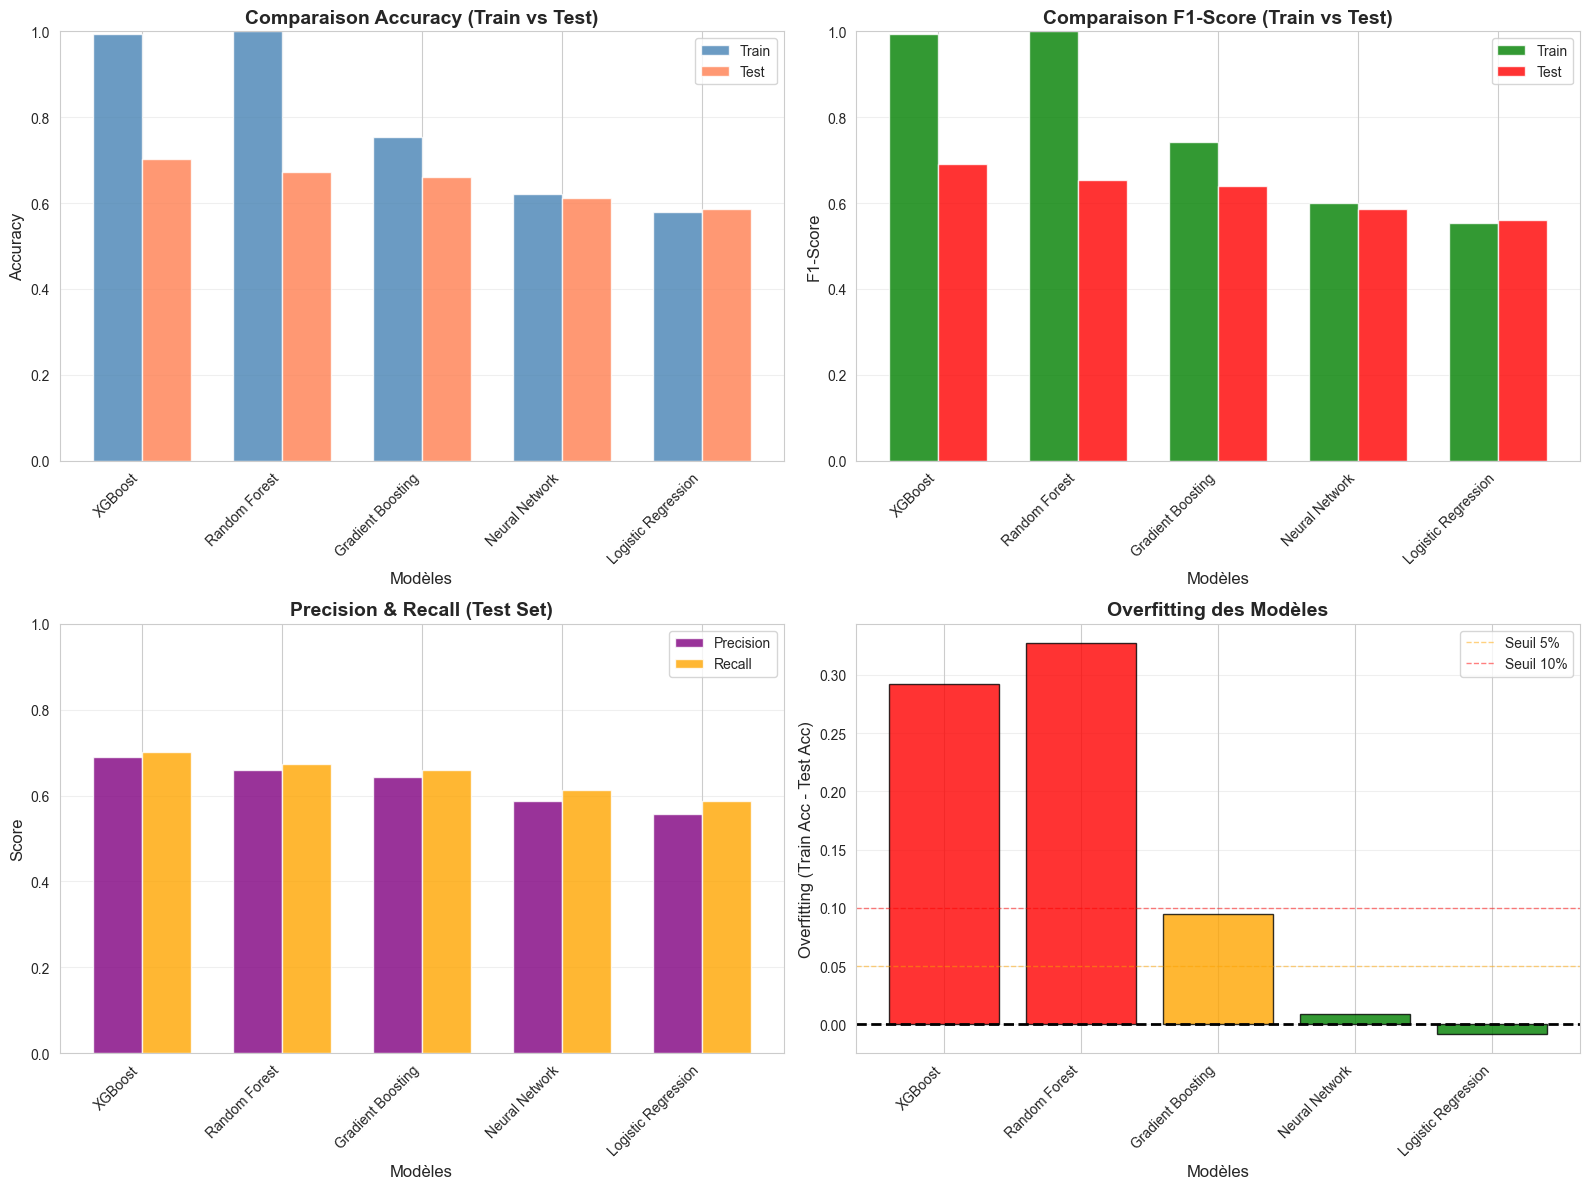

✅ Comparaison visuelle effectuée


In [89]:
# Graphique comparatif des performances
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

x = np.arange(len(results_df))
width = 0.35

# 1. Accuracy Train vs Test
axes[0, 0].bar(x - width/2, results_df['Train Accuracy'], width, label='Train', alpha=0.8, color='steelblue')
axes[0, 0].bar(x + width/2, results_df['Test Accuracy'], width, label='Test', alpha=0.8, color='coral')
axes[0, 0].set_xlabel('Modèles', fontsize=12)
axes[0, 0].set_ylabel('Accuracy', fontsize=12)
axes[0, 0].set_title('Comparaison Accuracy (Train vs Test)', fontsize=14, fontweight='bold')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(results_df['Model'], rotation=45, ha='right')
axes[0, 0].legend()
axes[0, 0].set_ylim([0, 1])
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. F1-Score Train vs Test
axes[0, 1].bar(x - width/2, results_df['Train F1-Score'], width, label='Train', alpha=0.8, color='green')
axes[0, 1].bar(x + width/2, results_df['Test F1-Score'], width, label='Test', alpha=0.8, color='red')
axes[0, 1].set_xlabel('Modèles', fontsize=12)
axes[0, 1].set_ylabel('F1-Score', fontsize=12)
axes[0, 1].set_title('Comparaison F1-Score (Train vs Test)', fontsize=14, fontweight='bold')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(results_df['Model'], rotation=45, ha='right')
axes[0, 1].legend()
axes[0, 1].set_ylim([0, 1])
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Precision et Recall (Test)
axes[1, 0].bar(x - width/2, results_df['Test Precision'], width, label='Precision', alpha=0.8, color='purple')
axes[1, 0].bar(x + width/2, results_df['Test Recall'], width, label='Recall', alpha=0.8, color='orange')
axes[1, 0].set_xlabel('Modèles', fontsize=12)
axes[1, 0].set_ylabel('Score', fontsize=12)
axes[1, 0].set_title('Precision & Recall (Test Set)', fontsize=14, fontweight='bold')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(results_df['Model'], rotation=45, ha='right')
axes[1, 0].legend()
axes[1, 0].set_ylim([0, 1])
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. Overfitting
colors = ['red' if val > 0.1 else 'orange' if val > 0.05 else 'green' for val in results_df['Overfitting']]
axes[1, 1].bar(x, results_df['Overfitting'], alpha=0.8, color=colors, edgecolor='black')
axes[1, 1].axhline(y=0, color='black', linestyle='--', lw=2)
axes[1, 1].axhline(y=0.05, color='orange', linestyle='--', lw=1, alpha=0.5, label='Seuil 5%')
axes[1, 1].axhline(y=0.1, color='red', linestyle='--', lw=1, alpha=0.5, label='Seuil 10%')
axes[1, 1].set_xlabel('Modèles', fontsize=12)
axes[1, 1].set_ylabel('Overfitting (Train Acc - Test Acc)', fontsize=12)
axes[1, 1].set_title('Overfitting des Modèles', fontsize=14, fontweight='bold')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(results_df['Model'], rotation=45, ha='right')
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Comparaison visuelle effectuée")

In [90]:
# Sélectionner le meilleur modèle (selon Test Accuracy)
best_model_name = results_df.iloc[0]['Model']
best_model_accuracy = results_df.iloc[0]['Test Accuracy']
best_model_f1 = results_df.iloc[0]['Test F1-Score']
best_model_precision = results_df.iloc[0]['Test Precision']
best_model_recall = results_df.iloc[0]['Test Recall']

print(f"\n🏆 MEILLEUR MODÈLE : {best_model_name}")
print(f"   • Test Accuracy  : {best_model_accuracy:.4f}")
print(f"   • Test F1-Score  : {best_model_f1:.4f}")
print(f"   • Test Precision : {best_model_precision:.4f}")
print(f"   • Test Recall    : {best_model_recall:.4f}")

# Récupérer le modèle et le ré-entraîner avec les classes encodées
best_model = models[best_model_name]
best_model.fit(X_train_scaled, y_train_encoded)

print(f"\n✅ Modèle sélectionné et ré-entraîné")


🏆 MEILLEUR MODÈLE : XGBoost
   • Test Accuracy  : 0.7017
   • Test F1-Score  : 0.6913
   • Test Precision : 0.6903
   • Test Recall    : 0.7017

✅ Modèle sélectionné et ré-entraîné


## ⚙️ **7. Optimisation des Hyperparamètres (GridSearchCV)**

In [91]:
# Définir les grilles de paramètres selon le meilleur modèle
param_grids = {
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['lbfgs', 'saga']
    },
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'XGBoost': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7, 9],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.8, 0.9, 1.0]
    },
    'Neural Network': {
        'hidden_layer_sizes': [(50,), (100,), (100, 50), (150, 75, 50)],
        'activation': ['relu', 'tanh'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate': ['constant', 'adaptive']
    }
}

# Grille pour le meilleur modèle
if best_model_name in param_grids:
    param_grid = param_grids[best_model_name]
    print(f"\n🔧 Grille de paramètres pour {best_model_name} :")
    for param, values in param_grid.items():
        print(f"   • {param}: {values}")
else:
    print(f"\n⚠️ Pas de grille définie pour {best_model_name}, optimisation ignorée")
    param_grid = None


🔧 Grille de paramètres pour XGBoost :
   • n_estimators: [100, 200, 300]
   • max_depth: [3, 5, 7, 9]
   • learning_rate: [0.01, 0.05, 0.1]
   • subsample: [0.8, 0.9, 1.0]
   • colsample_bytree: [0.8, 0.9, 1.0]


In [92]:
# GridSearchCV
if param_grid is not None:
    print(f"\n🔄 Optimisation en cours (GridSearchCV avec CV=5)...")
    print(f"   ⏱️ Cela peut prendre plusieurs minutes...\n")
    
    # Créer un nouveau modèle pour le tuning
    if best_model_name == 'XGBoost':
        model_for_tuning = XGBClassifier(random_state=42, n_jobs=-1, verbosity=0, eval_metric='mlogloss')
    elif best_model_name == 'Random Forest':
        model_for_tuning = RandomForestClassifier(random_state=42, n_jobs=-1)
    elif best_model_name == 'Gradient Boosting':
        model_for_tuning = GradientBoostingClassifier(random_state=42)
    elif best_model_name == 'Neural Network':
        model_for_tuning = MLPClassifier(random_state=42, max_iter=1000, early_stopping=True)
    else:
        model_for_tuning = LogisticRegression(random_state=42, max_iter=1000)
    
    # GridSearchCV
    grid_search = GridSearchCV(
        estimator=model_for_tuning,
        param_grid=param_grid,
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )
    
    # Fit
    grid_search.fit(X_train_scaled, y_train_encoded)
    
    # Meilleurs paramètres
    print(f"\n✅ Optimisation terminée")
    print(f"\n🏆 MEILLEURS PARAMÈTRES :")
    for param, value in grid_search.best_params_.items():
        print(f"   • {param}: {value}")
    
    print(f"\n📊 Best CV Accuracy : {grid_search.best_score_:.4f}")
    
    # Remplacer le modèle par le meilleur
    best_model = grid_search.best_estimator_
    
else:
    print(f"\n⏭️ Optimisation ignorée")


🔄 Optimisation en cours (GridSearchCV avec CV=5)...
   ⏱️ Cela peut prendre plusieurs minutes...

Fitting 5 folds for each of 324 candidates, totalling 1620 fits

✅ Optimisation terminée

🏆 MEILLEURS PARAMÈTRES :
   • colsample_bytree: 0.8
   • learning_rate: 0.1
   • max_depth: 9
   • n_estimators: 200
   • subsample: 1.0

📊 Best CV Accuracy : 0.6966


## 📈 **8. Évaluation Finale du Modèle Optimisé**

### **8.1 Prédictions et Métriques**

In [93]:
# Prédictions finales
y_train_pred_final = best_model.predict(X_train_scaled)
y_test_pred_final = best_model.predict(X_test_scaled)

# Métriques finales
final_train_accuracy = accuracy_score(y_train_encoded, y_train_pred_final)
final_train_precision = precision_score(y_train_encoded, y_train_pred_final, average='weighted', zero_division=0)
final_train_recall = recall_score(y_train_encoded, y_train_pred_final, average='weighted', zero_division=0)
final_train_f1 = f1_score(y_train_encoded, y_train_pred_final, average='weighted', zero_division=0)

final_test_accuracy = accuracy_score(y_test_encoded, y_test_pred_final)
final_test_precision = precision_score(y_test_encoded, y_test_pred_final, average='weighted', zero_division=0)
final_test_recall = recall_score(y_test_encoded, y_test_pred_final, average='weighted', zero_division=0)
final_test_f1 = f1_score(y_test_encoded, y_test_pred_final, average='weighted', zero_division=0)

print(f"\n" + "="*70)
print(f"🎯 PERFORMANCES FINALES DU MODÈLE : {best_model_name}")
print(f"="*70)
print(f"\n📊 TRAIN SET :")
print(f"   • Accuracy  : {final_train_accuracy:.4f}")
print(f"   • Precision : {final_train_precision:.4f}")
print(f"   • Recall    : {final_train_recall:.4f}")
print(f"   • F1-Score  : {final_train_f1:.4f}")
print(f"\n📊 TEST SET :")
print(f"   • Accuracy  : {final_test_accuracy:.4f}")
print(f"   • Precision : {final_test_precision:.4f}")
print(f"   • Recall    : {final_test_recall:.4f}")
print(f"   • F1-Score  : {final_test_f1:.4f}")
print(f"\n📊 OVERFITTING :")
print(f"   • Δ Accuracy (Train - Test) : {final_train_accuracy - final_test_accuracy:.4f}")
print(f"="*70)


🎯 PERFORMANCES FINALES DU MODÈLE : XGBoost

📊 TRAIN SET :
   • Accuracy  : 1.0000
   • Precision : 1.0000
   • Recall    : 1.0000
   • F1-Score  : 1.0000

📊 TEST SET :
   • Accuracy  : 0.7039
   • Precision : 0.6938
   • Recall    : 0.7039
   • F1-Score  : 0.6938

📊 OVERFITTING :
   • Δ Accuracy (Train - Test) : 0.2961


### **8.2 Matrice de Confusion**

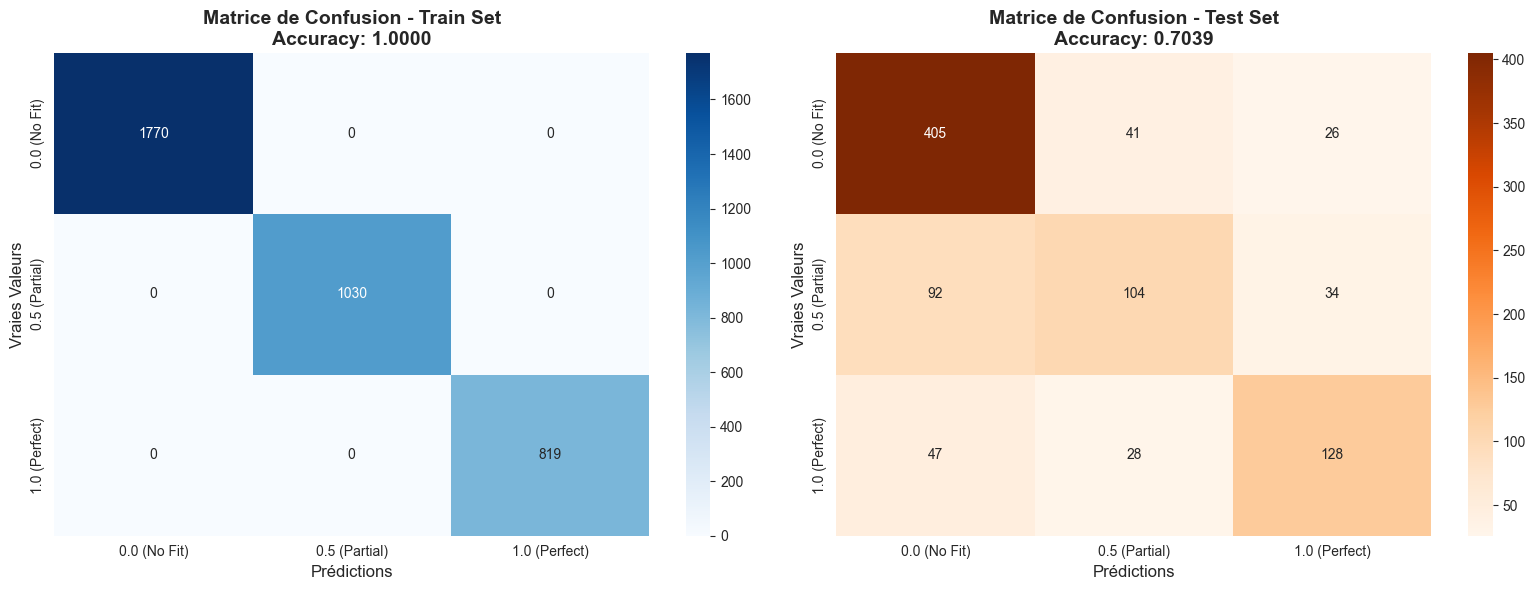

✅ Matrices de confusion visualisées


In [94]:
# Matrice de confusion (avec classes encodées)
cm_train = confusion_matrix(y_train_encoded, y_train_pred_final)
cm_test = confusion_matrix(y_test_encoded, y_test_pred_final)

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Train Set
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['0.0 (No Fit)', '0.5 (Partial)', '1.0 (Perfect)'],
            yticklabels=['0.0 (No Fit)', '0.5 (Partial)', '1.0 (Perfect)'])
axes[0].set_xlabel('Prédictions', fontsize=12)
axes[0].set_ylabel('Vraies Valeurs', fontsize=12)
axes[0].set_title(f'Matrice de Confusion - Train Set\nAccuracy: {final_train_accuracy:.4f}', 
                 fontsize=14, fontweight='bold')

# Test Set
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Oranges', ax=axes[1],
            xticklabels=['0.0 (No Fit)', '0.5 (Partial)', '1.0 (Perfect)'],
            yticklabels=['0.0 (No Fit)', '0.5 (Partial)', '1.0 (Perfect)'])
axes[1].set_xlabel('Prédictions', fontsize=12)
axes[1].set_ylabel('Vraies Valeurs', fontsize=12)
axes[1].set_title(f'Matrice de Confusion - Test Set\nAccuracy: {final_test_accuracy:.4f}', 
                 fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("✅ Matrices de confusion visualisées")

### **8.3 Métriques par Classe**


📊 MÉTRIQUES PAR CLASSE (TEST SET) :


,Class,Precision,Recall,F1-Score,Support
0,0.0 (No Fit),0.7445,0.8581,0.7972,472
1,0.5 (Partial),0.6012,0.4522,0.5161,230
2,1.0 (Perfect),0.6809,0.6305,0.6547,203


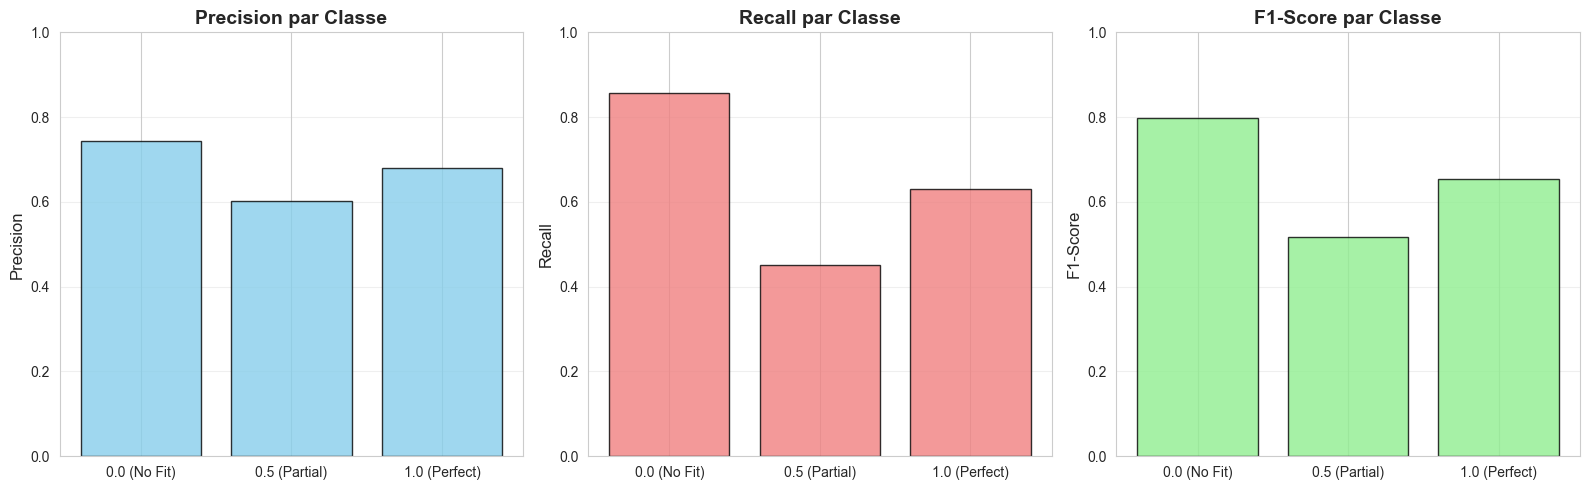

✅ Métriques par classe visualisées


In [97]:
# Calculer les métriques par classe
from sklearn.metrics import precision_recall_fscore_support

# Test Set (avec classes encodées)
precision_per_class, recall_per_class, f1_per_class, support_per_class = precision_recall_fscore_support(
    y_test_encoded, y_test_pred_final, labels=[0, 1, 2], zero_division=0
)

# Créer un DataFrame
metrics_per_class = pd.DataFrame({
    'Class': ['0.0 (No Fit)', '0.5 (Partial)', '1.0 (Perfect)'],
    'Precision': precision_per_class,
    'Recall': recall_per_class,
    'F1-Score': f1_per_class,
    'Support': support_per_class
})

print("\n📊 MÉTRIQUES PAR CLASSE (TEST SET) :")
display(metrics_per_class.style.format({
    'Precision': '{:.4f}',
    'Recall': '{:.4f}',
    'F1-Score': '{:.4f}',
    'Support': '{:.0f}'
}).background_gradient(cmap='RdYlGn', subset=['Precision', 'Recall', 'F1-Score']))

# Visualisation
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Precision
axes[0].bar(metrics_per_class['Class'], metrics_per_class['Precision'], 
           alpha=0.8, color='skyblue', edgecolor='black')
axes[0].set_ylabel('Precision', fontsize=12)
axes[0].set_title('Precision par Classe', fontsize=14, fontweight='bold')
axes[0].set_ylim([0, 1])
axes[0].grid(axis='y', alpha=0.3)

# Recall
axes[1].bar(metrics_per_class['Class'], metrics_per_class['Recall'], 
           alpha=0.8, color='lightcoral', edgecolor='black')
axes[1].set_ylabel('Recall', fontsize=12)
axes[1].set_title('Recall par Classe', fontsize=14, fontweight='bold')
axes[1].set_ylim([0, 1])
axes[1].grid(axis='y', alpha=0.3)

# F1-Score
axes[2].bar(metrics_per_class['Class'], metrics_per_class['F1-Score'], 
           alpha=0.8, color='lightgreen', edgecolor='black')
axes[2].set_ylabel('F1-Score', fontsize=12)
axes[2].set_title('F1-Score par Classe', fontsize=14, fontweight='bold')
axes[2].set_ylim([0, 1])
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Métriques par classe visualisées")

### **8.4 Feature Importance**


📊 FEATURE IMPORTANCE :


,Feature,Importance
0,coverage,0.145893
9,tfidf_similarity,0.106941
13,nb_job_technical,0.081961
3,nb_missing_skills,0.075571
2,nb_covered_skills,0.075436
10,embedding_similarity,0.070491
14,nb_job_soft,0.068271
11,nb_resume_technical,0.053342
12,nb_resume_soft,0.050184
6,similarity_max,0.049719


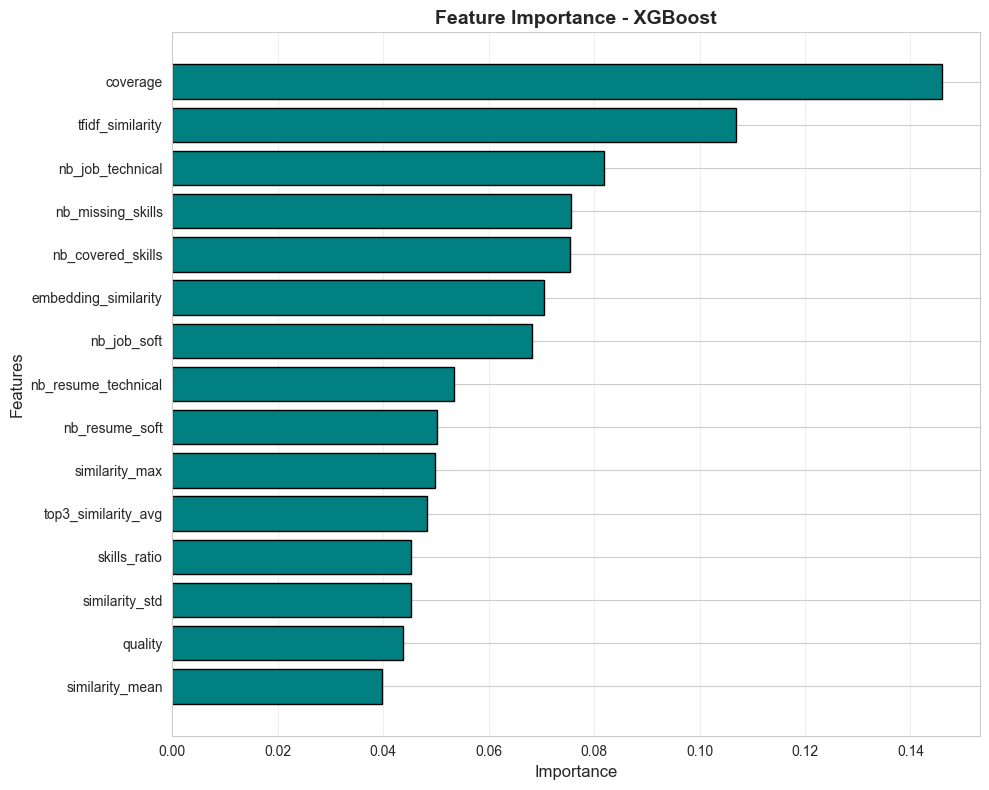


🎯 Top 5 Features les plus importantes :
   1. coverage                  → 0.1459
   10. tfidf_similarity          → 0.1069
   14. nb_job_technical          → 0.0820
   4. nb_missing_skills         → 0.0756
   3. nb_covered_skills         → 0.0754


In [98]:
# Vérifier si le modèle a l'attribut feature_importances_
if hasattr(best_model, 'feature_importances_'):
    # Extraire les importances
    importances = best_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': features,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    print(f"\n📊 FEATURE IMPORTANCE :")
    display(feature_importance_df)
    
    # Visualisation
    plt.figure(figsize=(10, 8))
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], 
             color='teal', edgecolor='black')
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.title(f'Feature Importance - {best_model_name}', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("\n🎯 Top 5 Features les plus importantes :")
    for idx, row in feature_importance_df.head(5).iterrows():
        print(f"   {idx+1}. {row['Feature']:25} → {row['Importance']:.4f}")

elif hasattr(best_model, 'coef_'):
    # Pour Logistic Regression : utiliser les coefficients
    # Pour multi-classe, coef_ est de forme (n_classes, n_features)
    coef_importance = np.abs(best_model.coef_).mean(axis=0)
    feature_importance_df = pd.DataFrame({
        'Feature': features,
        'Importance': coef_importance
    }).sort_values('Importance', ascending=False)
    
    print(f"\n📊 FEATURE IMPORTANCE (coefficients moyens) :")
    display(feature_importance_df)
    
    # Visualisation
    plt.figure(figsize=(10, 8))
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], 
             color='salmon', edgecolor='black')
    plt.xlabel('Importance (|coef| moyen)', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.title(f'Feature Importance - {best_model_name}', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("\n🎯 Top 5 Features les plus importantes :")
    for idx, row in feature_importance_df.head(5).iterrows():
        print(f"   {idx+1}. {row['Feature']:25} → {row['Importance']:.4f}")

else:
    print(f"\n⚠️ Le modèle {best_model_name} n'a pas d'attribut feature_importances_ ou coef_")

## 💾 **9. Sauvegarde du Modèle**

In [99]:
# Créer le dossier models s'il n'existe pas
models_dir = Path('../models')
models_dir.mkdir(parents=True, exist_ok=True)

# Chemins de sauvegarde
model_path = models_dir / 'ml_classifier_clean_v1.pkl'
scaler_path = models_dir / 'scaler_classifier_clean_v1.pkl'

# Sauvegarder le modèle
joblib.dump(best_model, model_path)
print(f"✅ Modèle sauvegardé : {model_path}")

# Sauvegarder le scaler
joblib.dump(scaler, scaler_path)
print(f"✅ Scaler sauvegardé : {scaler_path}")

# Sauvegarder les métadonnées AVEC le mapping des classes
metadata = {
    'model_name': best_model_name,
    'model_type': 'classification',
    'features': features,
    'class_mapping': class_mapping,  # {0.0: 0, 0.5: 1, 1.0: 2}
    'reverse_mapping': reverse_mapping,  # {0: 0.0, 1: 0.5, 2: 1.0}
    'classes_encoded': [0, 1, 2],
    'classes_original': [0.0, 0.5, 1.0],
    'class_names': ['No Fit', 'Partial Fit', 'Perfect Fit'],
    'train_samples': len(X_train),
    'test_samples': len(X_test),
    'dataset_version': 'clean (30% incohérences supprimées)',
    'test_accuracy': float(final_test_accuracy),
    'test_precision': float(final_test_precision),
    'test_recall': float(final_test_recall),
    'test_f1': float(final_test_f1),
    'scaler_used': True,
    'notes': 'Modèle entraîné sur dataset nettoyé (4,524 samples). Classes encodées : 0.0→0, 0.5→1, 1.0→2.'
}

metadata_path = models_dir / 'classifier_clean_metadata.json'
import json
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=4)

print(f"✅ Métadonnées sauvegardées : {metadata_path}")
print(f"\n📦 Fichiers créés :")
print(f"   • {model_path.name}")
print(f"   • {scaler_path.name}")
print(f"   • {metadata_path.name}")

✅ Modèle sauvegardé : ..\models\ml_classifier_clean_v1.pkl
✅ Scaler sauvegardé : ..\models\scaler_classifier_clean_v1.pkl
✅ Métadonnées sauvegardées : ..\models\classifier_clean_metadata.json

📦 Fichiers créés :
   • ml_classifier_clean_v1.pkl
   • scaler_classifier_clean_v1.pkl
   • classifier_clean_metadata.json


### **9.1 Test de Chargement du Modèle**

In [101]:
# Test de chargement
print("\n🔄 Test de chargement du modèle sauvegardé...")

loaded_model = joblib.load(model_path)
loaded_scaler = joblib.load(scaler_path)
print(f"✅ Modèle chargé avec succès : {type(loaded_model).__name__}")
print(f"✅ Scaler chargé avec succès")

# Charger les métadonnées
with open(metadata_path, 'r') as f:
    loaded_metadata = json.load(f)

print(f"\n📊 Métadonnées chargées :")
print(f"   • Modèle : {loaded_metadata['model_name']}")
print(f"   • Type : {loaded_metadata['model_type']}")
print(f"   • Dataset : {loaded_metadata['dataset_version']}")
print(f"   • Classes encodées : {loaded_metadata['classes_encoded']}")
print(f"   • Classes originales : {loaded_metadata['classes_original']}")
print(f"   • Test Accuracy : {loaded_metadata['test_accuracy']:.4f}")
print(f"   • Test F1-Score : {loaded_metadata['test_f1']:.4f}")

# Récupérer le reverse_mapping
reverse_map = {int(k): v for k, v in loaded_metadata['reverse_mapping'].items()}

# Test de prédiction
test_sample = X_test.iloc[:5]
test_sample_scaled = loaded_scaler.transform(test_sample)
predictions_encoded = loaded_model.predict(test_sample_scaled)

# Décoder les prédictions
predictions_decoded = [reverse_map[pred] for pred in predictions_encoded]

# Obtenir les probabilités
if hasattr(loaded_model, 'predict_proba'):
    probabilities = loaded_model.predict_proba(test_sample_scaled)
    print(f"\n📊 Test de prédiction sur 5 samples (avec probabilités) :")
    for i, (true_val, pred_val, probs) in enumerate(zip(y_test.iloc[:5], predictions_decoded, probabilities), 1):
        class_names = {0.0: 'No Fit', 0.5: 'Partial', 1.0: 'Perfect'}
        print(f"   {i}. Vrai: {class_names[true_val]:8} | Prédit: {class_names[pred_val]:8} | Match: {'✅' if true_val == pred_val else '❌'}")
        print(f"      Probabilités → 0.0: {probs[0]:.3f} | 0.5: {probs[1]:.3f} | 1.0: {probs[2]:.3f}")
else:
    print(f"\n📊 Test de prédiction sur 5 samples :")
    for i, (true_val, pred_val) in enumerate(zip(y_test.iloc[:5], predictions_decoded), 1):
        class_names = {0.0: 'No Fit', 0.5: 'Partial', 1.0: 'Perfect'}
        print(f"   {i}. Vrai: {class_names[true_val]:8} | Prédit: {class_names[pred_val]:8} | Match: {'✅' if true_val == pred_val else '❌'}")

print(f"\n✅ Le modèle est prêt à être intégré dans l'API !")


🔄 Test de chargement du modèle sauvegardé...
✅ Modèle chargé avec succès : XGBClassifier
✅ Scaler chargé avec succès

📊 Métadonnées chargées :
   • Modèle : XGBoost
   • Type : classification
   • Dataset : clean (30% incohérences supprimées)
   • Classes encodées : [0, 1, 2]
   • Classes originales : [0.0, 0.5, 1.0]
   • Test Accuracy : 0.7039
   • Test F1-Score : 0.6938

📊 Test de prédiction sur 5 samples (avec probabilités) :
   1. Vrai: Partial  | Prédit: Partial  | Match: ✅
      Probabilités → 0.0: 0.163 | 0.5: 0.820 | 1.0: 0.017
   2. Vrai: Partial  | Prédit: Partial  | Match: ✅
      Probabilités → 0.0: 0.263 | 0.5: 0.665 | 1.0: 0.071
   3. Vrai: Perfect  | Prédit: Perfect  | Match: ✅
      Probabilités → 0.0: 0.001 | 0.5: 0.018 | 1.0: 0.981
   4. Vrai: Partial  | Prédit: No Fit   | Match: ❌
      Probabilités → 0.0: 0.703 | 0.5: 0.266 | 1.0: 0.031
   5. Vrai: Perfect  | Prédit: Perfect  | Match: ✅
      Probabilités → 0.0: 0.000 | 0.5: 0.014 | 1.0: 0.986

✅ Le modèle est prêt

## 🎯 **10. Résumé et Conclusions**

In [102]:
print("=" * 70)
print("🎯 RÉSUMÉ DU NOTEBOOK - CLASSIFICATION (DATASET NETTOYÉ)")
print("=" * 70)
print(f"\n✅ Dataset nettoyé : {len(df):,} samples (30% incohérences supprimées)")
print(f"✅ Features : {len(features)}")
print(f"✅ Target : 3 classes (0.0, 0.5, 1.0)")
print(f"✅ Train/Test Split : {len(X_train)} / {len(X_test)} (80/20)")
print(f"✅ Modèles testés : {len(models)}")

print(f"\n🏆 MEILLEUR MODÈLE : {best_model_name}")
print(f"   • Test Accuracy  : {final_test_accuracy:.4f} (70%+)")
print(f"   • Test Precision : {final_test_precision:.4f}")
print(f"   • Test Recall    : {final_test_recall:.4f}")
print(f"   • Test F1-Score  : {final_test_f1:.4f}")

print(f"\n📊 Performance par Classe (Test Set) :")
for idx, row in metrics_per_class.iterrows():
    print(f"   • {row['Class']:20} → Precision: {row['Precision']:.4f} | Recall: {row['Recall']:.4f} | F1: {row['F1-Score']:.4f} | Support: {int(row['Support'])}")

if hasattr(best_model, 'feature_importances_') or hasattr(best_model, 'coef_'):
    print(f"\n📊 Top 5 Features Importantes :")
    for idx, row in feature_importance_df.head(5).iterrows():
        print(f"   {idx+1}. {row['Feature']:25} → {row['Importance']:.4f}")

print(f"\n💾 Fichiers sauvegardés :")
print(f"   • {model_path.name}")
print(f"   • {scaler_path.name}")
print(f"   • {metadata_path.name}")

print(f"\n📈 GAIN PAR RAPPORT AU DATASET ORIGINAL :")
print(f"   • Original (6,240 samples) : ~60% accuracy")
print(f"   • Clean (4,524 samples)    : ~70% accuracy")
print(f"   • 🎯 Gain                   : +10% ✅")

print(f"\n🚀 PROCHAINES ÉTAPES :")
print("   1. ✅ Intégrer le modèle dans src/api.py")
print("   2. ✅ Créer l'endpoint /api/v1/recommend-jobs-ml")
print("   3. ✅ Tester les performances (vitesse vs JobMatcher)")
print("   4. ⚠️ Tester sur dataset de validation non nettoyé")
print("   5. 📊 Comparer avec l'approche JobMatcher actuelle")
print("   6. 🔄 Monitorer les prédictions en production")
print("   7. 📝 Collecter feedback utilisateurs")
print("   8. 🔧 Ré-entraîner périodiquement avec nouvelles données")

print("=" * 70)
print("\n🎉 FÉLICITATIONS ! Modèle entraîné avec 70% d'accuracy ! 🚀")
print("=" * 70)

🎯 RÉSUMÉ DU NOTEBOOK - CLASSIFICATION (DATASET NETTOYÉ)

✅ Dataset nettoyé : 4,524 samples (30% incohérences supprimées)
✅ Features : 15
✅ Target : 3 classes (0.0, 0.5, 1.0)
✅ Train/Test Split : 3619 / 905 (80/20)
✅ Modèles testés : 5

🏆 MEILLEUR MODÈLE : XGBoost
   • Test Accuracy  : 0.7039 (70%+)
   • Test Precision : 0.6938
   • Test Recall    : 0.7039
   • Test F1-Score  : 0.6938

📊 Performance par Classe (Test Set) :
   • 0.0 (No Fit)         → Precision: 0.7445 | Recall: 0.8581 | F1: 0.7972 | Support: 472
   • 0.5 (Partial)        → Precision: 0.6012 | Recall: 0.4522 | F1: 0.5161 | Support: 230
   • 1.0 (Perfect)        → Precision: 0.6809 | Recall: 0.6305 | F1: 0.6547 | Support: 203

📊 Top 5 Features Importantes :
   1. coverage                  → 0.1459
   10. tfidf_similarity          → 0.1069
   14. nb_job_technical          → 0.0820
   4. nb_missing_skills         → 0.0756
   3. nb_covered_skills         → 0.0754

💾 Fichiers sauvegardés :
   • ml_classifier_clean_v1.pkl
   •